(c) Report the final training and the test accuracy. Report the number of samples used to obtained the final result

The training accuracy is 89.4%.
The test accuracy is 88.1%.
The training error is 10.6%.
The test error is 11.9%.
The number of samples used in training is the whole dataset(N_data).

In [1]:
# import library
from __future__ import absolute_import
from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()
import numpy as np
from scipy.special import logsumexp
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

In [2]:
# starter code
def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_mnist(N_data=None):
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    K_data = 10
    train_labels = one_hot(train_labels, K_data)
    test_labels = one_hot(test_labels, K_data)
    if N_data is not None:
        train_images = train_images[:N_data, :]
        train_labels = train_labels[:N_data, :]

    return train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    return cax


def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)

In [3]:
def log_softmax(images, weights, w0=None):
    """ Used in Q1 and Q2
        Inputs: images, and weights
        Returns the log_softmax values."""
    if w0 is None: w0 = np.zeros(weights.shape[1])

    # YOU NEED TO WRITE THIS PART
    # transfer Y into log softmax function
    predictions = np.dot(images, weights)  # (w^T)X
    exp_sum_predictions = logsumexp(predictions, axis=1, keepdims=True)  # ln(sum(exp((w^T)X)))
    log_Y = predictions - exp_sum_predictions  # (w^T)X - ln(sum(exp((w^T)X)))

    return log_Y

In [4]:
def cross_ent(log_Y, train_labels):
    """ Used in Q1
        Inputs: log of softmax values and training labels
        Returns the cross entropy."""

    # YOU NEED TO WRITE THIS PART
    cross_entropy = - np.sum(train_labels * log_Y)  # - sum(t_nk * log(y_nk)) for 10 classes
    
    return cross_entropy

In [5]:
def predict(log_Y):
    """ Used in Q1 and Q2
        Inputs: matrix of log softmax values
        Returns the predictions"""

    # YOU NEED TO WRITE THIS PART
    # Label the largest probability in each row as 1, the rest are 0s
    # keep the number in float32
    # The results would be like [[0,1,0,0,0,0,0,0,0,0],......]
    prediction = (log_Y == np.max(log_Y, axis=1, keepdims=True)).astype(np.float32)
    
        
    return prediction

In [6]:
def accuracy(log_Y, labels):
    """ Used in Q1 and Q2
        Inputs: matrix of log softmax values and 1-of-K labels
        Returns the accuracy based on predictions from log likelihood values"""
    
    # YOU NEED TO WRITE THIS PART
    prediction_new = predict(log_Y)
    
    # prediction_new would be like [[0,1,0,0,0,0,0,0,0,0],......]
    # prediction_new == 1 would create TRUE OR FALSE
    # labels would be like [[0,1,0,0,0,0,0,0,0,0],......]
    # labels == 1 would create TRUE OR FALSE as well
    # if at any one of position of prediction_new and labels both are True, then return 1, else we will get 0
    # In this example above, we have a one
    accuracy = ((prediction_new == 1) & (labels == 1)).any(axis=1).astype(np.float32)
    
    return accuracy

In [26]:
def train_log_regression(images, labels, learning_rate, max_iter):
    """ Used in Q1
        Inputs: train_images, train_labels, learning rate,
        and max num of iterations in gradient descent
        Returns the trained weights (w/o intercept)"""
    N_data, D_data = images.shape
    K_data = labels.shape[1]
    weights = np.zeros((D_data, K_data))

    iteration = []
    for i in range(max_iter):
        log_Y = log_softmax(images, weights, w0=None)  
        cross_entropy_final = cross_ent(log_Y, labels)
        
        # Add dimensions to matrices
        result = np.expand_dims(np.exp(log_Y) - labels, axis=1)  # N*1*C dimension, (Y_nk - T_nk)
        X = np.expand_dims(images, axis=2)  # N*D*1
        gradient = result * X # (X^T)(Y_nk - T_nk); dimension, N*D*C
        gradient = np.sum(gradient, axis=0) # dimension D*C
        weights -= learning_rate * gradient # w - n*gradient; gradient descent
        
        accuracy_final = accuracy(log_Y, labels)
        iteration = i

    w0 = None # No intercept for log-reg
    return weights, w0

(d) Plot the final weights obtained as 10 images.

The 10 images are ploted below.

The training accuracy is  0.894
The training error is  0.106
The test accuracy is  0.881
The test error is  0.119


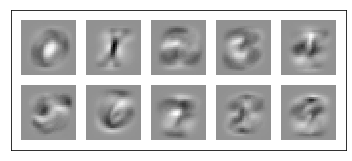

In [29]:
def main():
    N_data = None # Num of samples to be used in training
    # Set this to a small number while experimenting.
    # For log reg, finally use the entire training dataset for training (N_data=None).
    # For gda, use as many training samples as your computer can handle.
    
    train_images, train_labels, test_images, test_labels = load_mnist(N_data)

    # Q1: train logistic regression
    learning_rate, max_iter = .00001, 100
    weights, w0 = train_log_regression(train_images, train_labels, learning_rate, max_iter)
    save_images(weights.T, 'weights.png')
    
    training_set = log_softmax(train_images, weights)
    training_accuracy = accuracy(training_set, train_labels)
    training_accuracy_final = np.mean(training_accuracy)
    training_error =  1 - training_accuracy_final
    
    test_set = log_softmax(test_images, weights)
    test_accuracy = accuracy(test_set, test_labels)
    test_accuracy_final = np.mean(test_accuracy)
    test_error =  1 - test_accuracy_final
    

    print("The training accuracy is ", round(training_accuracy_final,3))
    print("The training error is ", round(training_error,3))
    print("The test accuracy is ", test_accuracy_final)
    print("The test error is ", round(test_error,3))

if __name__ == '__main__':
    main()
